In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn import tree
import pydotplus 
from IPython.display import Image 
from collections import Counter

In [2]:
#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [3]:
# Starting datasets
df = pd.read_csv('datasets/clustered_dataframe.csv', sep='\t', index_col=0)
df_customer = pd.read_csv('datasets/customer_dataframe_big.csv', sep='\t', index_col=0)

df_customer.set_index("CustomerID", inplace = True)
df_customer['Label'] = df['Label']
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4333 entries, 17850 to 12713
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TProd           4333 non-null   int64  
 1   DProd           4333 non-null   int64  
 2   MaxPO           4333 non-null   int64  
 3   MinPO           4333 non-null   int64  
 4   MeanProdOrder   4333 non-null   float64
 5   TSale           4333 non-null   float64
 6   TSaleWRet       4333 non-null   float64
 7   MinPSale        4333 non-null   float64
 8   MaxPSale        4333 non-null   float64
 9   MeanSaleOrder   4333 non-null   float64
 10  TRProd          4333 non-null   int64  
 11  MeanPSale       4333 non-null   float64
 12  TOrder          4333 non-null   int64  
 13  OrderMonth      4333 non-null   float64
 14  ProdMonth       4333 non-null   float64
 15  SaleMonth       4333 non-null   float64
 16  SETSaleQta      4333 non-null   float64
 17  SESaleQtaOrder  4333 non-nul

In [4]:
df_customer = discretize_data(df_customer,['MaxOrderMonth','Label'])

In [47]:
df_aux = df_customer.drop(columns=['TSaleWRet', 'MaxOrderMonth', 'Label', 'MeanProdOrder', 'MeanSaleOrder', 'MeanPSale', 'SETSaleQta', 'SESaleQtaOrder', 'MaxPO', 'MinPO', 'MinPSale', 'MaxPSale'], errors='ignore')
df_class = df_aux.copy()
df_class.tail()

TProd  DProd   TSale  TRProd  TOrder  OrderMonth  ProdMonth  \
CustomerID                                                                
13436          76     12  196.89       0       1       0.043      3.304   
15520         314     18  343.50       0       1       0.043     13.652   
13298          96      2  360.00       0       1       0.043      4.174   
14569          79     10  227.39       0       1       0.043      3.435   
12713         505     37  794.55       0       1       0.043     21.957   

            SaleMonth  MonthPresence  MaxOrderMonth_num  Label_num  
CustomerID                                                          
13436           8.560          0.043                  1          1  
15520          14.935          0.043                  1          1  
13298          15.652          0.043                  1          1  
14569           9.887          0.043                  1          1  
12713          34.546          0.043                 11          2

# Decision Tree

In [48]:
#to classify, we first need to split the dataset into train and test dataset.
#we can do so using train_test_split, in this case we select a stratified split
label = df_class.pop('Label_num')
train_set, test_set, train_label, test_label = train_test_split(df_class, label, stratify =label, test_size=0.30)

In [49]:
print(f"Class HighSpend\nTrain: {len(train_label[train_label == 0])}\nTest: {len(test_label[test_label == 0])}")

Class HighSpend
Train: 18
Test: 8


In [50]:
#define a decision tree and fit it
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=4, min_samples_split=30, min_samples_leaf=5)
dt = dt.fit(train_set, train_label)

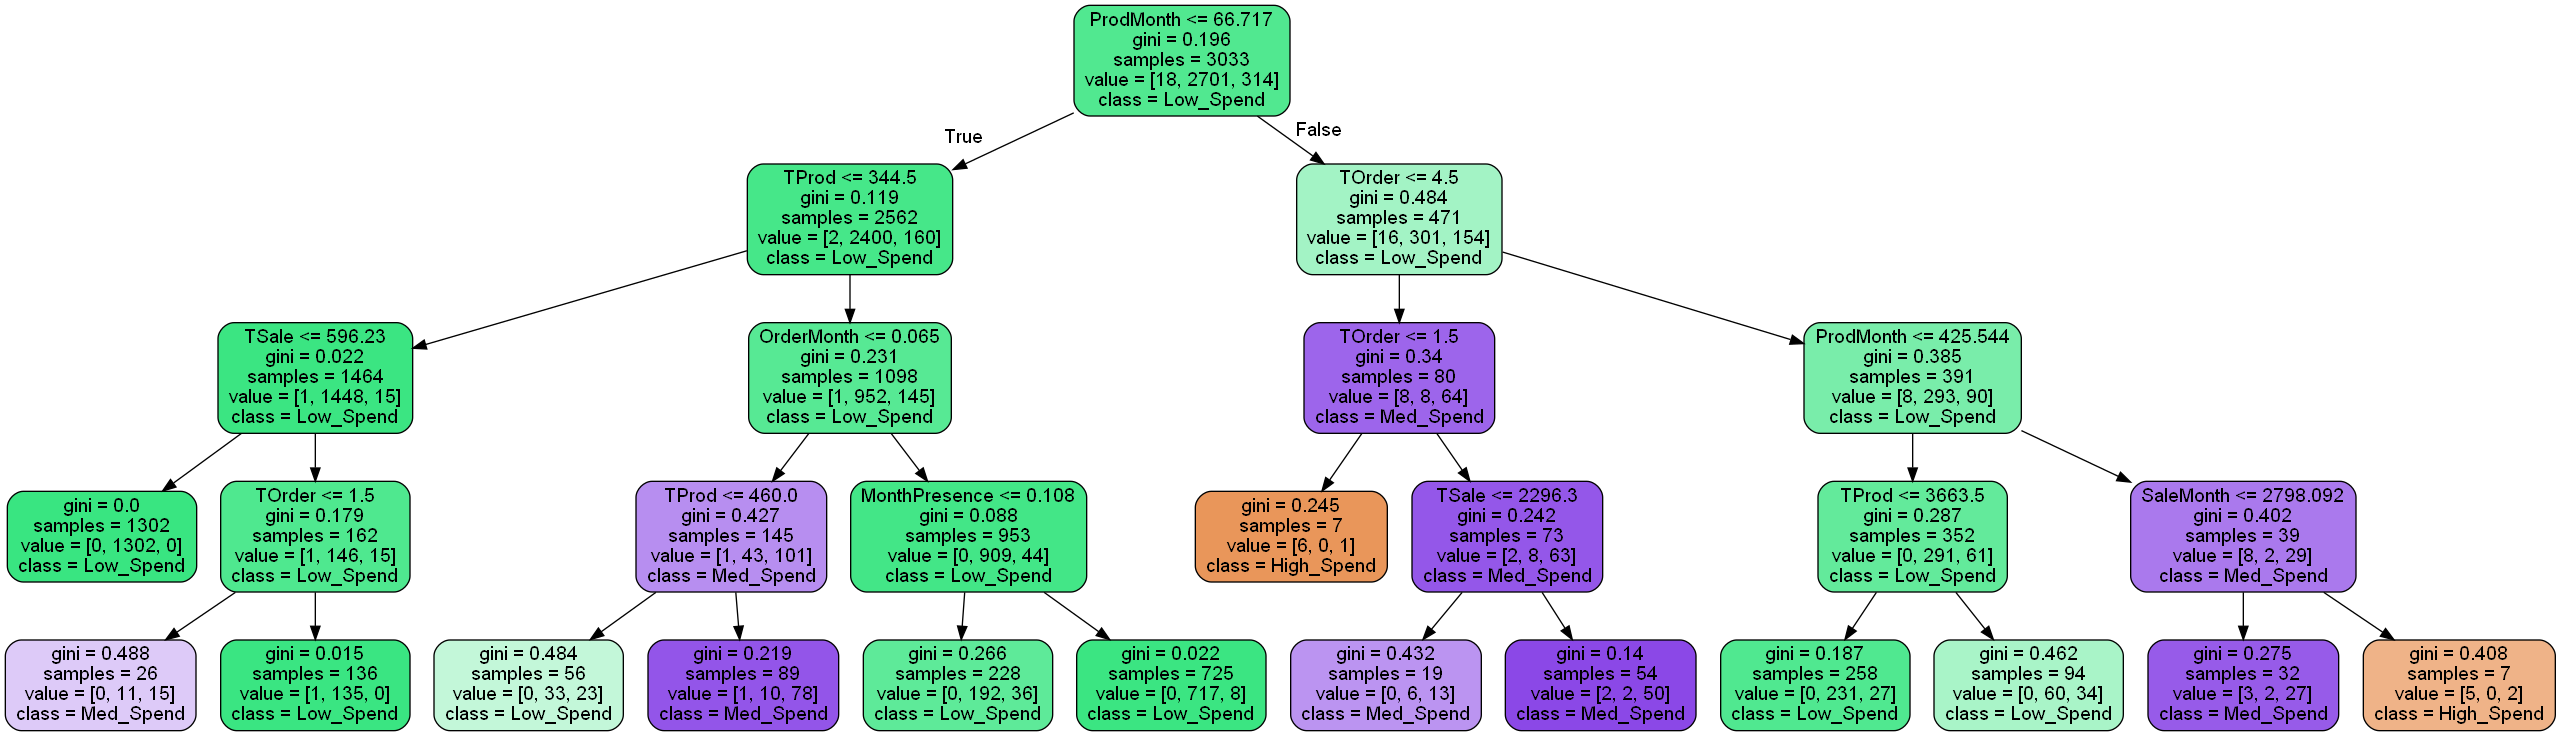

In [51]:
#visualize the actual decision tree obtained  
classes = ['High_Spend','Low_Spend','Med_Spend']
dot_data = tree.export_graphviz(dt, out_file=None, feature_names=list(train_set.columns), class_names=classes, filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [52]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

In [53]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
from sklearn import metrics
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.9442795911638642
Accuracy test set  0.9246153846153846
Precision train set  0.9402737815067144
Recall train set  0.9442795911638642
F1 score train set  0.9396682946559585
Support train set  (array([0.78571429, 0.95391211, 0.83181818]), array([0.61111111, 0.98852277, 0.58280255]), array([0.6875    , 0.97090909, 0.68539326]), array([  18, 2701,  314], dtype=int64))


In [54]:
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, test_pred, target_names=classes))

In [55]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

  High_Spend       0.71      0.62      0.67         8
   Low_Spend       0.94      0.98      0.96      1157
   Med_Spend       0.72      0.44      0.55       135

    accuracy                           0.92      1300
   macro avg       0.79      0.68      0.73      1300
weighted avg       0.92      0.92      0.92      1300



***

## Adding Oversampling

In [14]:
_train_set, _test_set, _train_label, _test_label = train_set, test_set, train_label, test_label

In [76]:
from imblearn.over_sampling import SMOTE
smote_train = SMOTE(sampling_strategy='not majority', k_neighbors=5)
smote_test = SMOTE(sampling_strategy={1: Counter(_test_label)[1], 2: Counter(_test_label)[2], 0: Counter(_test_label)[2] }, k_neighbors=5)
train_set, train_label = smote_train.fit_resample(_train_set, _train_label)
test_set, test_label = smote_test.fit_resample(_test_set, _test_label)

print(train_label.value_counts())
print(test_label.value_counts())

2    2701
1    2701
0    2701
Name: Label_num, dtype: int64
1    1157
2     135
0     135
Name: Label_num, dtype: int64


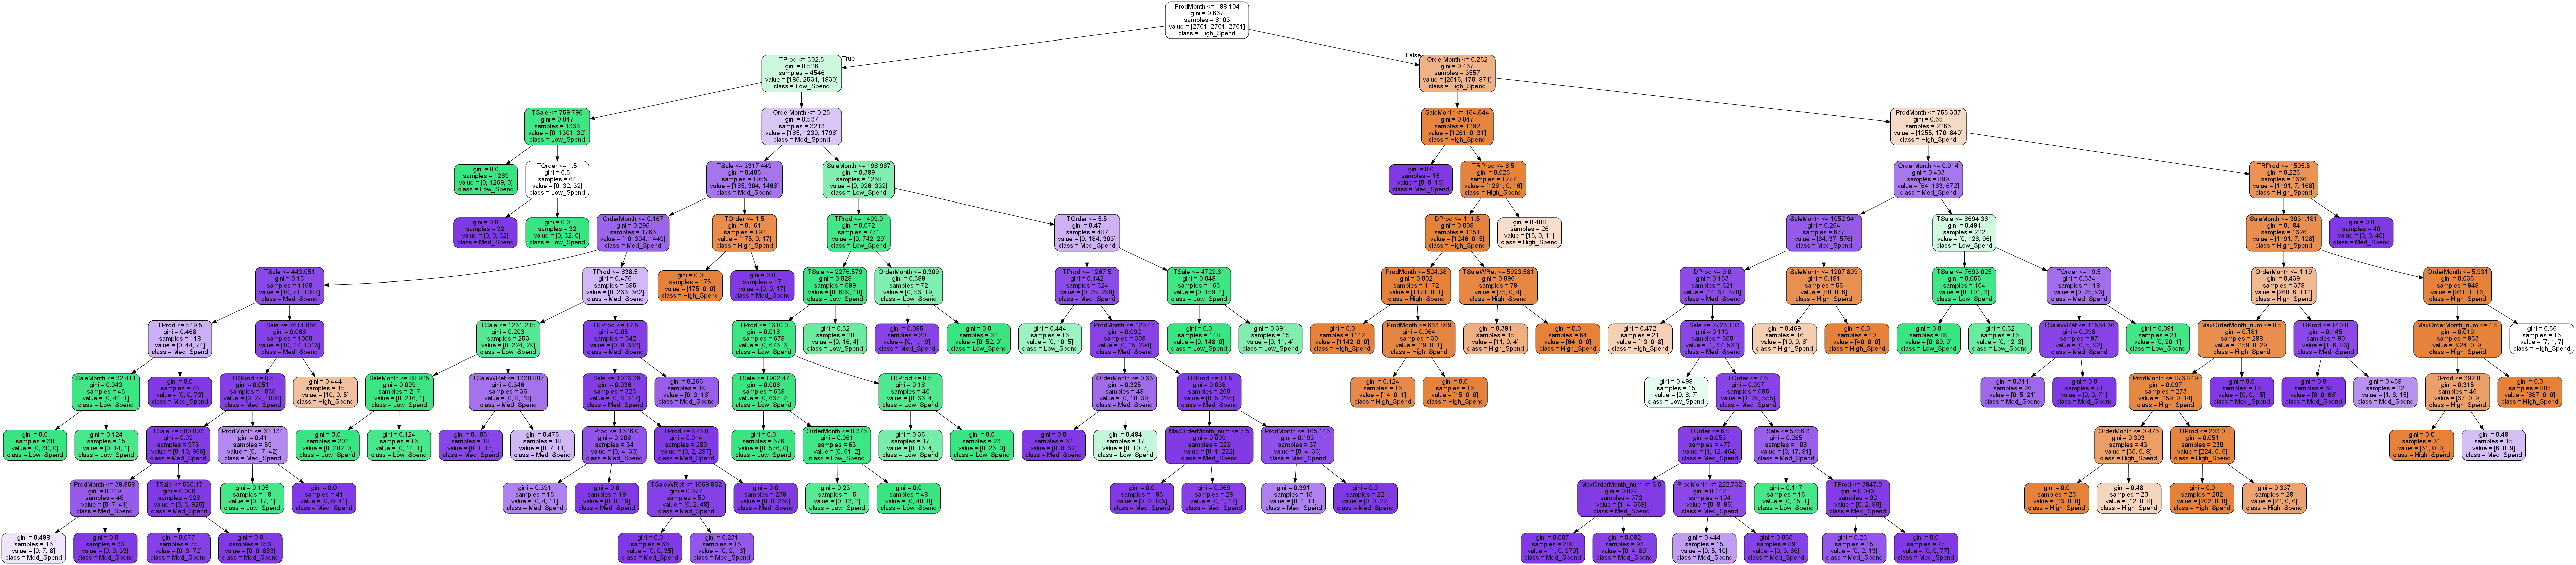

In [79]:
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=10, min_samples_split=10, min_samples_leaf=15)
dt = dt.fit(train_set, train_label)
classes = ['High_Spend','Low_Spend','Med_Spend']
dot_data = tree.export_graphviz(dt, out_file=None, feature_names=list(train_set.columns), class_names=classes, filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [80]:
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

  High_Spend       0.91      0.82      0.86       135
   Low_Spend       0.98      0.97      0.98      1157
   Med_Spend       0.68      0.78      0.73       135

    accuracy                           0.94      1427
   macro avg       0.86      0.86      0.86      1427
weighted avg       0.94      0.94      0.94      1427



***

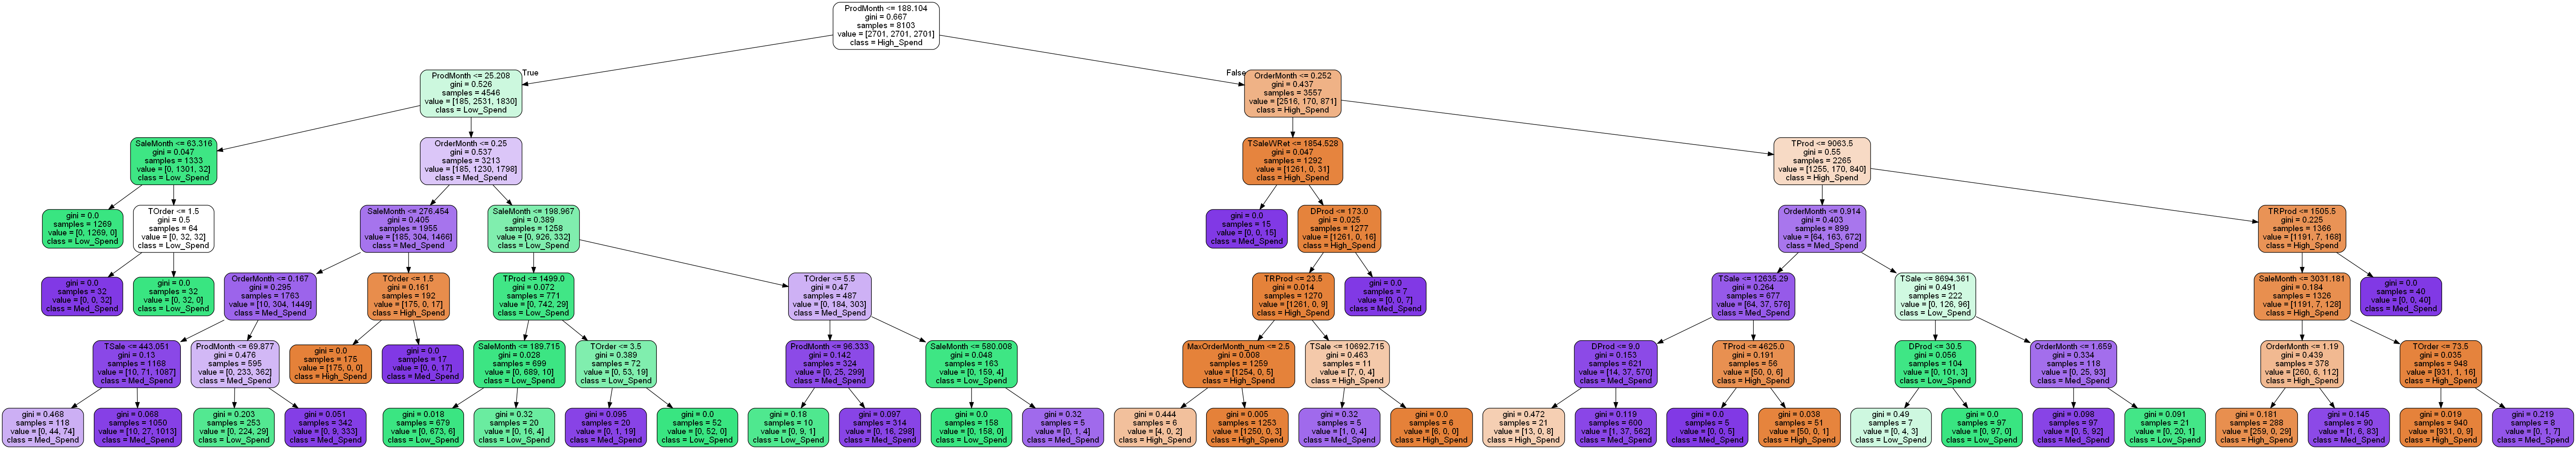

In [107]:
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=6, min_samples_split=5, min_samples_leaf=5)
dt = dt.fit(train_set, train_label)
classes = ['High_Spend','Low_Spend','Med_Spend']
dot_data = tree.export_graphviz(dt, out_file=None, feature_names=list(train_set.columns), class_names=classes, filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [108]:
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

  High_Spend       0.93      0.79      0.86       135
   Low_Spend       0.98      0.93      0.95      1157
   Med_Spend       0.51      0.80      0.62       135

    accuracy                           0.90      1427
   macro avg       0.81      0.84      0.81      1427
weighted avg       0.93      0.90      0.91      1427



***

In [37]:
from imblearn.over_sampling import SMOTE

smote_train = SMOTE(sampling_strategy='not majority', k_neighbors=5)
train_set, train_label = smote_train.fit_resample(_train_set, _train_label)

highest =Counter(_test_label)[1]
fraction = 4
strat = {1: math.ceil(highest), 2: math.ceil(highest / (fraction-1)), 0: math.ceil(highest / fraction) }
smote_test = SMOTE(sampling_strategy=strat, k_neighbors=5)
test_set, test_label = smote_test.fit_resample(_test_set, _test_label)

print(train_label.value_counts())
print(test_label.value_counts())

2    2701
1    2701
0    2701
Name: Label_num, dtype: int64
1    1157
2     386
0     290
Name: Label_num, dtype: int64


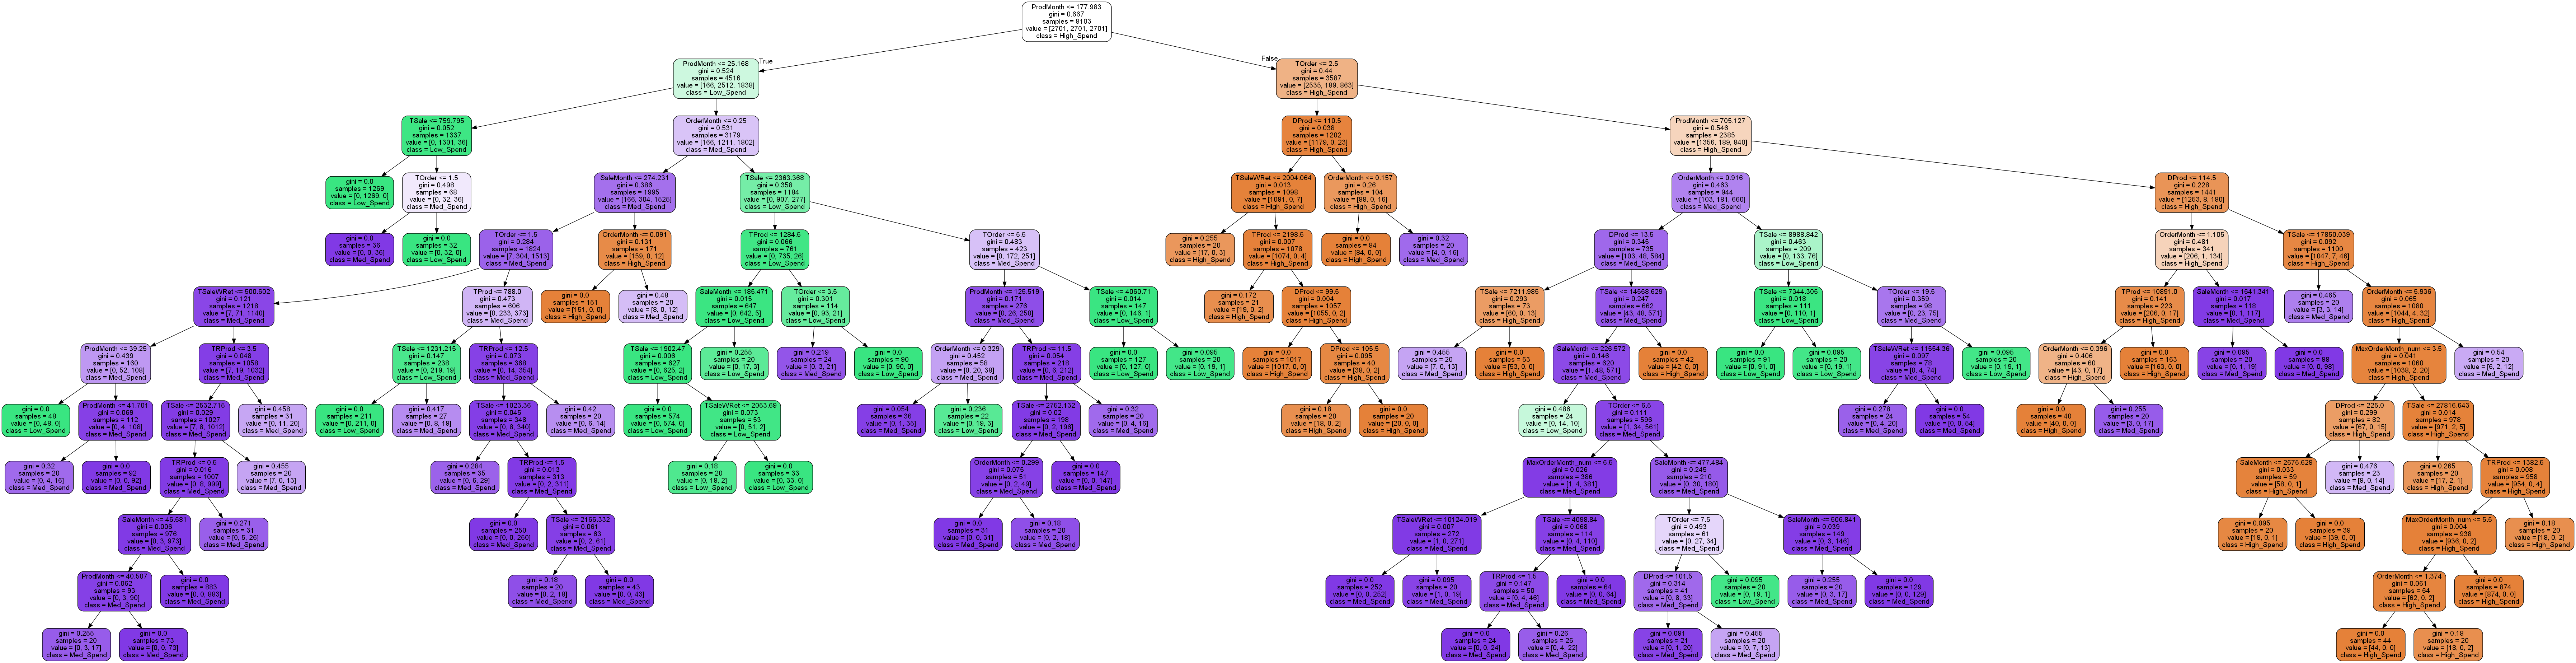

In [38]:
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=15, min_samples_split=10, min_samples_leaf=20)
dt = dt.fit(train_set, train_label)
classes = ['High_Spend','Low_Spend','Med_Spend']
dot_data = tree.export_graphviz(dt, out_file=None, feature_names=list(train_set.columns), class_names=classes, filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [39]:
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

  High_Spend       0.95      0.84      0.89       290
   Low_Spend       0.96      0.97      0.97      1157
   Med_Spend       0.80      0.86      0.83       386

    accuracy                           0.93      1833
   macro avg       0.90      0.89      0.90      1833
weighted avg       0.93      0.93      0.93      1833

